## Bose-Hubbard model

Consider a lattice with bosons on each site, where operators are defined as the following:
- $\hat{a}_i, \hat{a}^\dagger_i$ - boson annihilation and creation operators for site $i$,
- $\hat{n}_i$ - boson occupation number operator.

_Bose-Hubbard model includes three terms:_
- chemical potential term $\mu$, which tells the price of adding more particles to the system, 
- hopping amplitude $t$, which defines how likely the bosons are hopping between the nearest neighbour lattice sites
- onsite interaction potential $U$, which prevents bosons from occupying the same lattice site


_Bose-Hubbard hamiltonian:_

$\begin{equation}H = -t\sum_{\left<i, j\right>}\left(\hat{a}_i^\dagger\hat{a}_j + \hat{a}_i\hat{a}_j^\dagger\right) + \frac{U}{2}\sum_{i}\hat{n}_i(\hat{n}_i - 1) - \mu \sum_i \hat{n}_i\end{equation}$


__What can be modelled by Bose-Hubbard model?__

- bosonic atoms on a lattice, superfluid-insulator transition
- certain magnetic insulators



__Plan:__
- Mean-field phase diagram of Bose-Hubbard model
- DMRG phase diagram of Bose-Hubbard model for 1D chain wiht superfluid and Mott insulator phases
- What happens when bond dimension approaches 1 in DMRG simulation? Mean-field solution?
- Measure correlators for each phase, such as superfluid susceptibility, compressibility, correlation radius, density

__Theory:__

The model can be better understood by considering the limiting cases. 

1. $t = 0$ _- no hopping between lattice sites._

In this case the bosons uncouple, so we arrive at sum of one-body hamiltonians

$H = \frac{U}{2}\sum_{i}\hat{n}_i(\hat{n}_i - 1) - \mu \sum_i \hat{n}_i $. 

Clearly, due to the independency of lattice sites, the groundstate should have the same occupation number for all lattice sites, so one of the $\left|\psi_n \right> = \left| n, n, ...,n \right>$ is a groundstate with $E_n = \left< \psi_n \right|H\left| \psi_n \right> = N(\frac{U}{2}n(n - 1) - \mu n)$, where $N$ is the number of lattice sites. To get the groundstate energy, we should find minimum of $E_n$ over occupation number $n$, so the condition is $\partial_n E_n = 0 \Leftrightarrow Un-\frac{U}{2}-\mu = 0$. Taking into account that $n$ is integer, we receive $n = \text{argmin}\left(E_{\left\lfloor{\frac{1}{2} + \frac{\mu}{U}}\right\rfloor},E_{\left\lceil{\frac{1}{2} + \frac{\mu}{U}}\right\rceil}\right) $. What just happened? Now we know that in the limit of no hopping each lattice site contains the same number of bosons, which increases discretely as we tune $\mu/U$. This phase of matter is called Mott insulator. 

2. $U = 0$ _- no onsite interaction._ 

In this case the hamiltonian takes the form

$H = -t\sum_{\left<i, j\right>}\left(\hat{a}_i^\dagger\hat{a}_j + \hat{a}_i\hat{a}_j^\dagger\right) - \mu \sum_i \hat{n}_i$. Consider 1D chain of atoms

In [1]:
using ITensors, ITensorMPS
using CSV, Tables
using NPZ
using PyPlot
using CurveFit
include("Bose_Hubbard.jl");

In [9]:
μ = 0.0:0.02:1.1
U = 1.0
t = 0.0:0.02:0.4
bonddim_list = [1, 2, 3, 4, 5, 10, 20]
nsweeps_list = [20, 20, 20, 30, 30, 40, 60]
names = [""]

base_filename = "/Users/goloshch/SandBox/DMRG/"

@suppress for k in eachindex(bonddim_list)
    result = zeros((length(μ), length(t)))
    name = "PhaseDiagram:N=50_maxoccupation=5_D=$(bonddim_list[k])_nsweeps=$(nsweeps_list[k]).npz"
    filename = base_filename * name

    @suppress for i in eachindex(μ)
        @suppress for j in eachindex(t)
            H, sites = BoseHubbard(t[j], μ[i], U; max_occupation=5);
            energy, psi = Simulation(H, sites; maxdim=bonddim_list[k], nsweeps=nsweeps_list[k])
            result[i, j] = AverageOccupation(psi);
        end
        npzwrite(filename, Dict("mu" => μ, "t" => t, "U" => U, "navg" => result))
    end
end

InterruptException: InterruptException:

In [17]:
μ = 0.0:0.1:5.0;
U = 1.0
t = 0.05
navg = zeros(length(μ))


@suppress for i in eachindex(μ)
    H, sites = BoseHubbard(t, μ[i], U; max_occupation=8, N=30)
    energy, psi = Simulation(H, sites;maxdim=10,nsweeps=60)
    navg[i] = AverageOccupation(psi)
end;

base_filename = "/Users/goloshch/SandBox/DMRG/data/"
filename = base_filename*"ladder.npz"
npzwrite(filename, Dict("navg" => navg, "mu" => μ, "t" => t, "U" => U))

1. Запустить параллельные вычисления на сервере для фазовой диаграммы с $D=5$ и $nsweeps = 100$. 
2. Посчитать корреляционный радиус. Сначала считается корреляционная функция $\Gamma(r) = \left<a_j^\dagger a_{j+r}\right>$, затем корреляционный радиус из фита

In [23]:
C = zeros((3, 3))
size(C)[1]

3

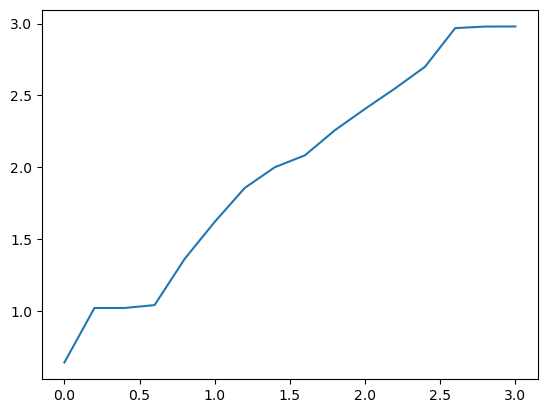

In [56]:
figure()
plot(μ, result)
gcf()

### Корреляционные функции

In [89]:
μ = 0.4
t = 0.4
U = 1.0

L = 50
D = 10
nsweeps = 50
max_occupation = 3

H, sites = BoseHubbard(t, μ, U; N=L, max_occupation=max_occupation)
energy, psi = @suppress Simulation(H, sites; maxdim=D, nsweeps=nsweeps)

C = Correlation(psi)
Cr_f = CorrelationCord(C; avg=false)
ncalc = Occupation(psi);

In [100]:
correlation_matrix(psi, "n", "n")

50×50 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     

In [117]:
L = 50
l_mu = 10
l_t = 20

a = zeros((L, L, l_mu, l_t))

for i in 1:l_mu
    for j in 1:l_t
        a[:, :, i, j] = correlation_matrix(psi, "n", "n")
    end
end

In [118]:
a

50×50×10×20 Array{Float64, 4}:
[:, :, 1, 1] =
 1.40643  1.04308  1.15821  1.17854  …  1.19623  1.19385  1.19635  1.14386
 1.04308  1.60736  1.12316  1.22586     1.25112  1.24863  1.25125  1.19635
 1.15821  1.12316  1.60711  1.12303     1.24851  1.24602  1.24863  1.19384
 1.17854  1.22586  1.12303  1.6145      1.251    1.24851  1.25112  1.19623
 1.18498  1.23938  1.22353  1.12639     1.25115  1.24866  1.25127  1.19637
 1.18717  1.24234  1.23647  1.22539  …  1.25008  1.24759  1.2502   1.19535
 1.18794  1.24306  1.23888  1.23833     1.24862  1.24613  1.24874  1.19395
 1.18842  1.24341  1.23976  1.2409      1.24743  1.24495  1.24755  1.19282
 1.18906  1.24396  1.24059  1.24222     1.2469   1.24442  1.24702  1.19231
 1.19004  1.2449   1.24173  1.24361     1.24703  1.24454  1.24715  1.19243
 ⋮                                   ⋱                             
 1.19231  1.24702  1.24442  1.2469      1.24221  1.24059  1.24395  1.18902
 1.1928   1.24754  1.24493  1.24741     1.2409   1.23976  1.2

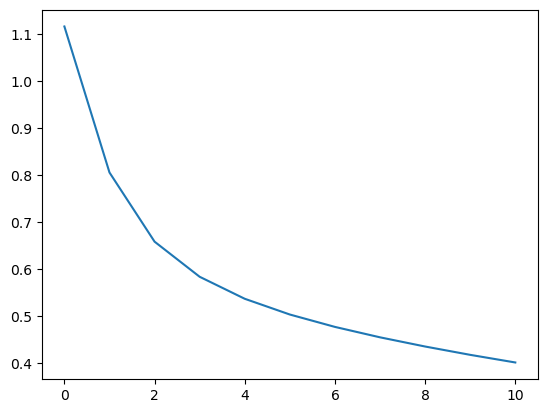

In [269]:
figure()
max_r = 10
plot(Cr_f[center:center+max_r])
gcf()

In [88]:
psi

UndefVarError: UndefVarError: `psi` not defined

In [ ]:
energy, psi = @suppress Simulation(H, sites; maxdim=D, nsweeps=nsweeps)

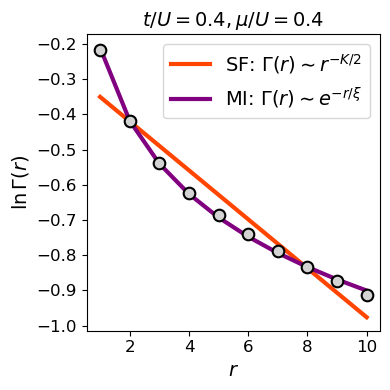

In [271]:
figure()
max_r = 10
center=Int(ceil(L//2))
r = 1:max_r
a, b = linear_fit(r, log.(Cr_f[center+1:center+max_r]))
c, d = linear_fit(log.(r), log.(Cr_f[center+1:center+max_r]))

figure(figsize=(4,4))
plot(r, a .+ b*r, 
    label="SF: "*"\$ \\Gamma(r) \\sim r^{-K/2}\$", 
    linewidth=3,
    color="orangered",
    zorder=-3) 
plot(r, c .+ d*log.(r), 
    label="MI: "*"\$ \\Gamma(r) \\sim e^{-r/\\xi}\$", 
    linewidth=3,
    color="purple") 
scatter(r, log.(Cr_f[center+1:center+max_r]), 
        color="lightgray", 
        zorder=4, 
        s=70,
        edgecolors="black",
        linewidth=1.5)
xlabel("\$ r\$", fontsize=14)
ylabel("\$\\ln \\Gamma(r) \$", fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)

title("\$ t/U=0.4, \\mu/U=0.4 \$", fontsize=14)
legend(fontsize=14)
tight_layout()
savefig("results/correlation_function_MI.pdf", dpi=200)
gcf()

In [22]:
t = 0.05
V = 0.4
U = 1.0
μ = 0.0:0.05:2.0
Spi = zeros(length(μ))
sigma = zeros(length(μ))
navg = zeros(length(μ))
xi = zeros(length(μ))
K = zeros(length(μ))

function nstd(psi)
    n = expect(psi, "n")
    navg = sum(n)/length(n)
    nstd = sum(n .^2)/length(n) - navg^2

    return nstd
end


@suppress for i in eachindex(μ)
    H, sites = ExtendedBoseHubbard(t, μ[i], U, V)
    energy, psi = Simulation(H, sites; maxdim=20, nsweeps=100)
    Spi[i] = StructureFactor(psi)
    sigma[i] = nstd(psi)
    navg[i] = AverageOccupation(psi)
    xi[i], K[i] = CorrelationLengths(psi)
end

filename = "data/EBHM_Scan_V_04_t_005.npz"
npzwrite(filename, Dict("mu" => μ, "t" => t, "U" => 1.0, "navg" => navg, "K" => K, "xi" => xi, "Spi" => Spi, "nstd" => sigma))

In [42]:
filename = "data/EBHM_Scan_V_04_t_005.npz"
data = NPZ.npzread(filename)
μ = data["mu"]
t = data["t"]
xi = data["xi"]
K = data["K"]
Spi = data["Spi"]
sigma = data["nstd"]

41-element Vector{Float64}:
 0.004633205503609933
 0.010204589159791555
 0.01909416382388887
 0.03550193349438141
 0.11598239104097446
 0.11598179081749765
 0.11598219969698403
 0.11599239617024171
 0.12059000555037341
 0.12058998507523627
 ⋮
 0.0294337771749813
 0.025637327651434116
 0.0241225583077469
 0.02257557387266451
 0.022525605595302034
 0.023832122241221665
 0.025311764242632817
 0.031130633461470936
 0.03686818565352956

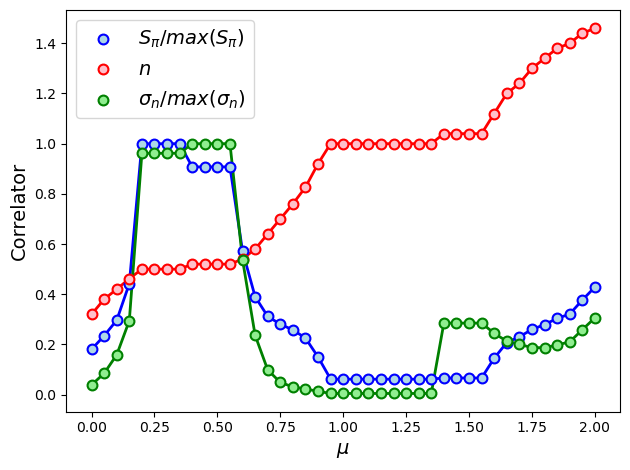

In [44]:
figure()
s = 50
lw = 1.5
plot(μ, Spi / maximum(Spi), linewidth=2, color="blue",zorder=-2)
scatter(μ, Spi / maximum(Spi), 
        label="\$ S_{\\pi} / max(S_{\\pi})\$", 
        color="lightblue",
        edgecolors="blue",
        linewidth=lw,
        s=s)

plot(μ, navg, linewidth=2, color="red",zorder=-2)
scatter(μ, navg, label="\$ n \$", 
        color="pink",
        edgecolors="red",
        linewidth=lw,
        s=s)

plot(μ, sigma / maximum(sigma), linewidth=2, color="green",zorder=-2)
scatter(μ, sigma / maximum(sigma), 
        color="lightgreen", 
        edgecolors="green",
        linewidth=lw,
        s=s,
        label="\$ \\sigma_{n} / max(\\sigma_{n}) \$")

xlabel("\$ \\mu \$", fontsize=14)
ylabel("Correlator", fontsize=14)
legend(fontsize=14)
tight_layout()

# savefig("results/CDW_signatures.pdf")
gcf()

In [73]:
t = 0.02
V = 0.4
U = 1.0
μ = 0.2:0.1:0.5
Spi = zeros(length(μ))
sigma = zeros(length(μ))
navg = zeros(length(μ))
xi = zeros(length(μ))
K = zeros(length(μ))
psi_list = []

@suppress for i in eachindex(μ)
    H, sites = ExtendedBoseHubbard(t, μ[i], U, V; N=51)
    energy, psi = Simulation(H, sites; maxdim=15, nsweeps=100)
    Spi[i] = StructureFactor(psi)
    sigma[i] = nstd(psi)
    navg[i] = AverageOccupation(psi)
    xi[i], K[i] = CorrelationLengths(psi)
    push!(psi_list, psi)
end

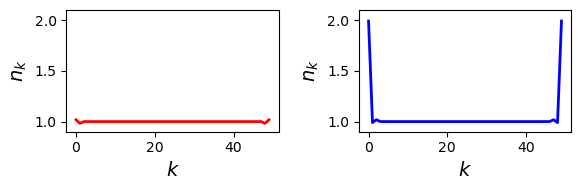

In [65]:
n3, n4 = expect(psi_list[3], "n"), expect(psi_list[4], "n")
fontsize = 14

figure(figsize=(6,2))
subplot(121)
plot(n3, color="red", linewidth=2)
ylim(0.9, 2.1)
ylabel("\$ n_{k} \$", fontsize=fontsize)
xlabel("\$ k \$", fontsize=fontsize)

subplot(122)
plot(n4, color="blue", linewidth=2)
ylim(0.9, 2.1)
ylabel("\$ n_{k} \$", fontsize=fontsize)
xlabel("\$ k \$", fontsize=fontsize)

tight_layout()
savefig("results/edge_states.pdf", dpi=200)
savefig("results/edge_states.png", dpi=200)

gcf()

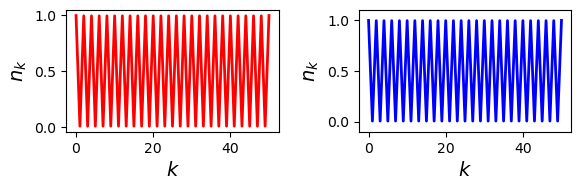

In [87]:
n3, n4 = expect(psi_list[1], "n"), expect(psi_list[4], "n")
fontsize = 14

figure(figsize=(6,2))
subplot(121)
plot(n3, color="red", linewidth=2)
# ylim(-0.1, 1.1)
ylabel("\$ n_{k} \$", fontsize=fontsize)
xlabel("\$ k \$", fontsize=fontsize)

subplot(122)
plot(n4, color="blue", linewidth=2)
ylim(-0.1, 1.1)
ylabel("\$ n_{k} \$", fontsize=fontsize)
xlabel("\$ k \$", fontsize=fontsize)

tight_layout()
# savefig("results/edge_states.pdf", dpi=200)
# savefig("results/edge_states.png", dpi=200)

gcf()

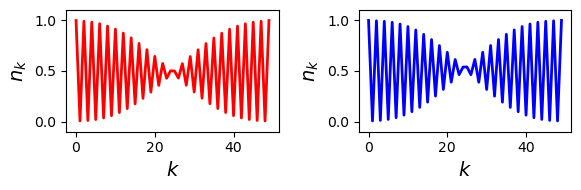

In [69]:
n1, n2 = expect(psi_list[1], "n"), expect(psi_list[2], "n")
fontsize = 14

figure(figsize=(6,2))
subplot(121)
plot(n1, color="red", linewidth=2)
ylim(-0.1, 1.1)
ylabel("\$ n_{k} \$", fontsize=fontsize)
xlabel("\$ k \$", fontsize=fontsize)

subplot(122)
plot(n2, color="blue", linewidth=2)
ylim(-0.1, 1.1)
ylabel("\$ n_{k} \$", fontsize=fontsize)
xlabel("\$ k \$", fontsize=fontsize)

tight_layout()
savefig("results/edge_states_DW.pdf", dpi=200)
savefig("results/edge_states_DW.png", dpi=200)

gcf()

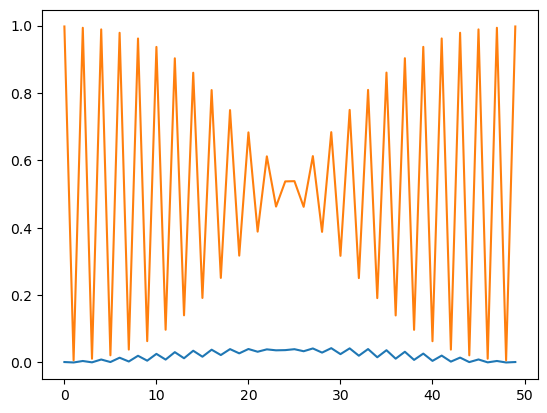

In [71]:
n1, n2 = expect(psi_list[1], "n"), expect(psi_list[2], "n")
figure()
plot(n2 - n1)
plot(n2)
gcf()
# ylim(0.0, 2.0)